## 1️⃣ Setup Environment

In [1]:
# ============================================================
# Cell 1: Check GPU Availability
# ============================================================
import torch

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU detected! Go to Runtime > Change runtime type > GPU")

PyTorch version: 2.9.0+cu126
Device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB


In [2]:
# ============================================================
# Cell 2: Setup Model Directory
# ============================================================
import os

MODEL_DIR = './models'
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"📁 Modelo se guardará en: {MODEL_DIR}")
print("💡 Al final del entrenamiento podrás descargar el .pth")

📁 Modelo se guardará en: ./models
💡 Al final del entrenamiento podrás descargar el .pth


## 2️⃣ Import Libraries & Define Components

In [3]:
# ============================================================
# Cell 4: Import All Required Libraries
# ============================================================
import os
import random
from dataclasses import dataclass
from typing import Any

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0
from tqdm.auto import tqdm

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [4]:
# ============================================================
# Cell 5: Utility Functions
# ============================================================

def seed_everything(seed: int = 42) -> None:
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For deterministic behavior (slightly slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_device() -> torch.device:
    """Automatically detect best available device."""
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def accuracy_top1(logits: torch.Tensor, targets: torch.Tensor) -> float:
    """Compute top-1 accuracy."""
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()


@dataclass
class Checkpoint:
    """Container for training checkpoint data."""
    epoch: int
    model_state: dict
    optimizer_state: dict
    best_val_acc: float
    config: dict


def save_checkpoint(path: str, checkpoint: Checkpoint) -> None:
    """Save checkpoint to disk."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': checkpoint.epoch,
        'model_state': checkpoint.model_state,
        'optimizer_state': checkpoint.optimizer_state,
        'best_val_acc': checkpoint.best_val_acc,
        'config': checkpoint.config,
    }, path)


def load_checkpoint(path: str, map_location='cpu') -> dict:
    """Load checkpoint from disk."""
    return torch.load(path, map_location=map_location, weights_only=False)


class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience: int = 5, min_delta: float = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.should_stop = False
    
    def __call__(self, score: float) -> bool:
        if self.best_score is None:
            self.best_score = score
            return False
        
        if score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        
        return self.should_stop


print("✓ Utility functions defined!")

✓ Utility functions defined!


In [5]:
# ============================================================
# Cell 6: Model Builder (EfficientNet-B0)
# ============================================================

def build_efficientnet_b0(num_classes: int = 10, pretrained: bool = True) -> nn.Module:
    """
    Build EfficientNet-B0 with custom classifier head.
    
    Args:
        num_classes: Number of output classes (10 for CIFAR-10)
        pretrained: Load ImageNet pretrained weights
    """
    weights = EfficientNet_B0_Weights.DEFAULT if pretrained else None
    model = efficientnet_b0(weights=weights)
    
    # Replace classifier (1000 ImageNet classes -> num_classes)
    in_features = model.classifier[1].in_features  # 1280
    model.classifier[1] = nn.Linear(in_features, num_classes)
    
    return model


def set_trainable(model: nn.Module, train_classifier_only: bool = True) -> None:
    """
    Configure which layers to train.
    
    Args:
        train_classifier_only: If True, freeze backbone (Feature Extraction)
    """
    if not train_classifier_only:
        for p in model.parameters():
            p.requires_grad = True
        return
    
    # Freeze all layers
    for p in model.parameters():
        p.requires_grad = False
    
    # Unfreeze classifier only
    for p in model.classifier.parameters():
        p.requires_grad = True


def count_parameters(model: nn.Module) -> tuple:
    """Count total and trainable parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


print("✓ Model builder defined!")

✓ Model builder defined!


In [6]:
# ============================================================
# Cell 7: Data Loading & Augmentation
# ============================================================

@dataclass
class DataConfig:
    """Data loading configuration."""
    data_dir: str = './data'
    batch_size: int = 64
    num_workers: int = 2
    image_size: int = 224


def build_transforms(image_size: int):
    """Build train and validation transforms."""
    # ImageNet normalization (required for pretrained model)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
    
    train_tfms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Extra augmentation for Colab
        transforms.ToTensor(),
        normalize,
    ])
    
    val_tfms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        normalize,
    ])
    
    return train_tfms, val_tfms


def create_cifar10_loaders(cfg: DataConfig):
    """Create CIFAR-10 data loaders."""
    train_tfms, val_tfms = build_transforms(cfg.image_size)
    
    train_ds = datasets.CIFAR10(
        root=cfg.data_dir, train=True, download=True, transform=train_tfms
    )
    val_ds = datasets.CIFAR10(
        root=cfg.data_dir, train=False, download=True, transform=val_tfms
    )
    
    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    
    return train_loader, val_loader


# CIFAR-10 class names
CLASS_NAMES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print("✓ Data loading functions defined!")

✓ Data loading functions defined!


In [7]:
# ============================================================
# Cell 8: Training & Evaluation Engine
# ============================================================

@dataclass
class EpochResult:
    """Container for epoch metrics."""
    loss: float
    acc: float


def train_one_epoch(model, loader, optimizer, loss_fn, device) -> EpochResult:
    """Train for one epoch."""
    model.train()
    total_loss, total_acc, batches = 0.0, 0.0, 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += accuracy_top1(logits.detach(), targets)
        batches += 1
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{total_acc/batches:.4f}'})
    
    return EpochResult(loss=total_loss/batches, acc=total_acc/batches)


@torch.no_grad()
def evaluate(model, loader, loss_fn, device) -> EpochResult:
    """Evaluate the model."""
    model.eval()
    total_loss, total_acc, batches = 0.0, 0.0, 0
    
    for images, targets in tqdm(loader, desc='Evaluating', leave=False):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        
        logits = model(images)
        loss = loss_fn(logits, targets)
        
        total_loss += loss.item()
        total_acc += accuracy_top1(logits, targets)
        batches += 1
    
    return EpochResult(loss=total_loss/batches, acc=total_acc/batches)


print("✓ Training engine defined!")

✓ Training engine defined!


## 3️⃣ Training Configuration

In [8]:
# ============================================================
# Cell 9: Training Configuration
# ============================================================

# 🎛️ HYPERPARAMETERS - Modify these as needed!
CONFIG = {
    # Training settings
    'epochs': 5,              # Number of training epochs
    'batch_size': 64,          # Batch size (increase if GPU has more memory)
    'lr': 3e-4,                # Learning rate
    'weight_decay': 1e-4,      # L2 regularization
    
    # Transfer learning
    'freeze_backbone': False,   # True = Feature Extraction, False = Fine-tuning
    
    # Early stopping
    'patience': 5,             # Epochs without improvement before stopping
    
    # Scheduler
    'scheduler': 'cosine',     # 'cosine', 'plateau', or 'none'
    
    # Other
    'seed': 42,
    'num_workers': 0,          # 0 = avoid multiprocessing issues in Colab/VS Code
    'image_size': 224,
}

# Display configuration
print("📋 Training Configuration:")
print("=" * 40)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

📋 Training Configuration:
  epochs: 5
  batch_size: 64
  lr: 0.0003
  weight_decay: 0.0001
  freeze_backbone: False
  patience: 5
  scheduler: cosine
  seed: 42
  num_workers: 0
  image_size: 224


## 4️⃣ Run Training

In [9]:
# ============================================================
# Cell 10: Initialize Everything
# ============================================================

# Set seed for reproducibility
seed_everything(CONFIG['seed'])

# Device
device = get_device()
print(f"🖥️ Using device: {device}")

# Data loaders
data_cfg = DataConfig(
    batch_size=CONFIG['batch_size'],
    num_workers=CONFIG['num_workers'],
    image_size=CONFIG['image_size'],
)
train_loader, val_loader = create_cifar10_loaders(data_cfg)
print(f"📊 Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Model
model = build_efficientnet_b0(num_classes=10, pretrained=True)
set_trainable(model, train_classifier_only=CONFIG['freeze_backbone'])
model.to(device)

total_params, trainable_params = count_parameters(model)
print(f"🧠 Model parameters: {trainable_params:,} trainable / {total_params:,} total")
print(f"🔒 Freeze backbone: {CONFIG['freeze_backbone']}")

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=CONFIG['lr'],
    weight_decay=CONFIG['weight_decay'],
)

# Scheduler
scheduler = None
if CONFIG['scheduler'] == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=CONFIG['epochs'], eta_min=CONFIG['lr'] * 0.01
    )
    print("📈 Using CosineAnnealingLR scheduler")
elif CONFIG['scheduler'] == 'plateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )
    print("📈 Using ReduceLROnPlateau scheduler")

# Early stopping
early_stopping = EarlyStopping(patience=CONFIG['patience'])
print(f"⏹️ Early stopping enabled (patience={CONFIG['patience']})")

print("\n✓ All components initialized!")

🖥️ Using device: cuda


100%|██████████| 170M/170M [00:04<00:00, 41.3MB/s] 


📊 Train batches: 782, Val batches: 157
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 161MB/s]


🧠 Model parameters: 4,020,358 trainable / 4,020,358 total
🔒 Freeze backbone: False
📈 Using CosineAnnealingLR scheduler
⏹️ Early stopping enabled (patience=5)

✓ All components initialized!


In [10]:
# ============================================================
# Cell 11: Training Loop
# ============================================================

# Training history for plotting
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
model_path = f"{MODEL_DIR}/efficientnet_cifar10_best.pth"

print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60 + "\n")

for epoch in range(1, CONFIG['epochs'] + 1):
    print(f"Epoch {epoch}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Train
    train_result = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    
    # Validate
    val_result = evaluate(model, val_loader, loss_fn, device)
    
    # Update scheduler
    current_lr = optimizer.param_groups[0]['lr']
    if scheduler is not None:
        if CONFIG['scheduler'] == 'plateau':
            scheduler.step(val_result.acc)
        else:
            scheduler.step()
    
    # Record history
    history['train_loss'].append(train_result.loss)
    history['train_acc'].append(train_result.acc)
    history['val_loss'].append(val_result.loss)
    history['val_acc'].append(val_result.acc)
    history['lr'].append(current_lr)
    
    # Print metrics
    print(f"  Train Loss: {train_result.loss:.4f} | Train Acc: {train_result.acc:.4f}")
    print(f"  Val Loss:   {val_result.loss:.4f} | Val Acc:   {val_result.acc:.4f}")
    print(f"  LR: {current_lr:.2e}")
    
    # Save best model
    if val_result.acc > best_val_acc:
        best_val_acc = val_result.acc
        save_checkpoint(
            model_path,
            Checkpoint(
                epoch=epoch,
                model_state=model.state_dict(),
                optimizer_state=optimizer.state_dict(),
                best_val_acc=best_val_acc,
                config=CONFIG,
            )
        )
        print(f"  ✅ New best model saved! (acc={best_val_acc:.4f})")
    
    # Early stopping check
    if early_stopping(val_result.acc):
        print(f"\n⚠️ Early stopping triggered at epoch {epoch}")
        break
    
    print()

print("\n" + "="*60)
print(f"🎉 TRAINING COMPLETE!")
print(f"   Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Model saved to: {model_path}")
print("="*60)


🚀 STARTING TRAINING

Epoch 1/5
----------------------------------------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 0.3325 | Train Acc: 0.8920
  Val Loss:   0.1525 | Val Acc:   0.9476
  LR: 3.00e-04
  ✅ New best model saved! (acc=0.9476)

Epoch 2/5
----------------------------------------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 0.1396 | Train Acc: 0.9521
  Val Loss:   0.1337 | Val Acc:   0.9550
  LR: 2.72e-04
  ✅ New best model saved! (acc=0.9550)

Epoch 3/5
----------------------------------------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 0.0816 | Train Acc: 0.9719
  Val Loss:   0.1152 | Val Acc:   0.9632
  LR: 1.97e-04
  ✅ New best model saved! (acc=0.9632)

Epoch 4/5
----------------------------------------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 0.0466 | Train Acc: 0.9844
  Val Loss:   0.0995 | Val Acc:   0.9704
  LR: 1.06e-04
  ✅ New best model saved! (acc=0.9704)

Epoch 5/5
----------------------------------------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 0.0293 | Train Acc: 0.9909
  Val Loss:   0.0973 | Val Acc:   0.9731
  LR: 3.14e-05
  ✅ New best model saved! (acc=0.9731)


🎉 TRAINING COMPLETE!
   Best Validation Accuracy: 0.9731 (97.31%)
   Model saved to: ./models/efficientnet_cifar10_best.pth


## 5️⃣ Visualize Results

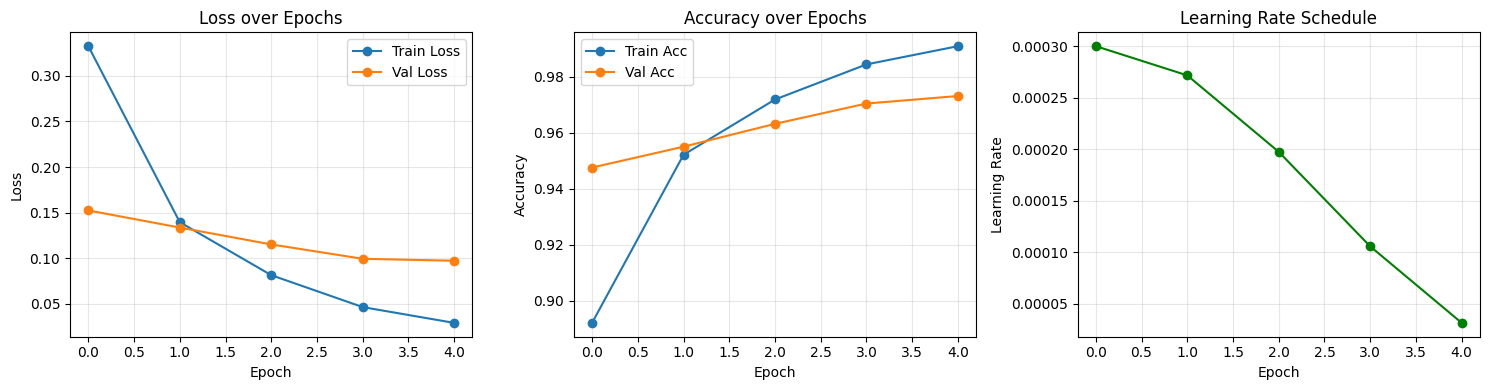


📊 Final Results:
   Best Val Accuracy: 0.9731 (97.31%)


In [11]:
# ============================================================
# Cell 12: Plot Training History
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate plot
axes[2].plot(history['lr'], marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Final Results:")
print(f"   Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

## 6️⃣ Model Evaluation & Analysis

In [12]:
# ============================================================
# Cell 13: Load Best Model and Generate Predictions
# ============================================================

# Load the best model
ckpt = load_checkpoint(model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()

print(f"✓ Loaded best model from epoch {ckpt['epoch']}")
print(f"  Validation accuracy: {ckpt['best_val_acc']:.4f}")

# Generate predictions on test set
@torch.no_grad()
def get_all_predictions(model, loader, device):
    """Get predictions for entire dataset."""
    all_preds, all_labels, all_probs = [], [], []
    
    for images, labels in tqdm(loader, desc='Predicting'):
        images = images.to(device)
        logits = model(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

predictions, true_labels, probabilities = get_all_predictions(model, val_loader, device)
test_accuracy = (predictions == true_labels).mean()
print(f"\n✓ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

✓ Loaded best model from epoch 5
  Validation accuracy: 0.9731


Predicting:   0%|          | 0/157 [00:00<?, ?it/s]


✓ Test Accuracy: 0.9733 (97.33%)


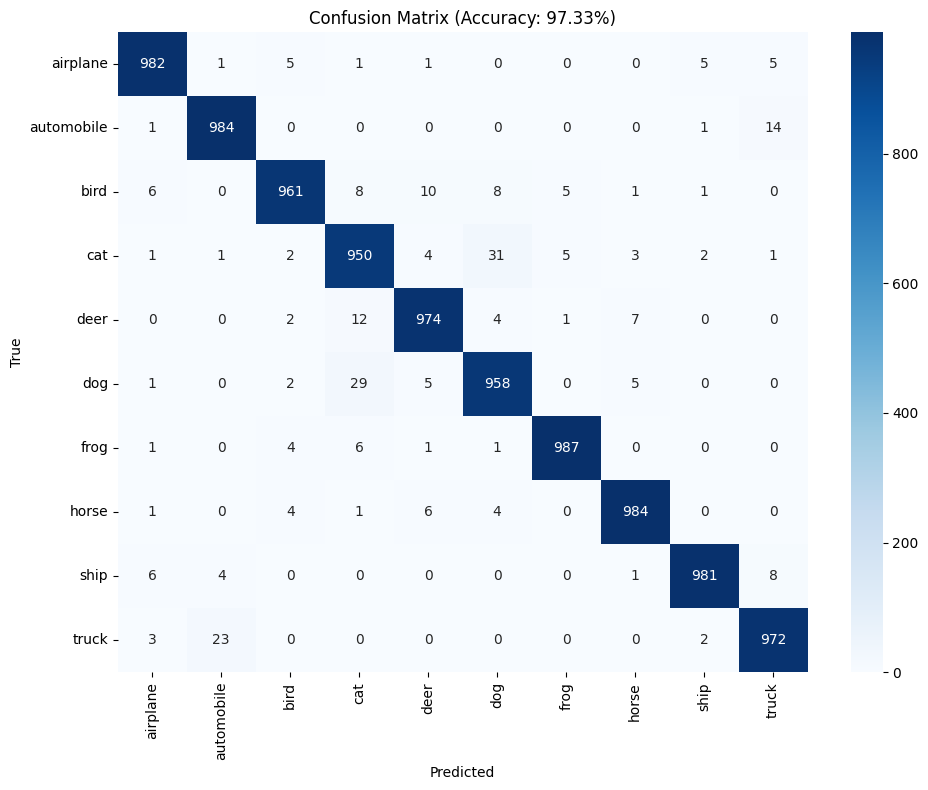


📋 Classification Report:
              precision    recall  f1-score   support

    airplane       0.98      0.98      0.98      1000
  automobile       0.97      0.98      0.98      1000
        bird       0.98      0.96      0.97      1000
         cat       0.94      0.95      0.95      1000
        deer       0.97      0.97      0.97      1000
         dog       0.95      0.96      0.96      1000
        frog       0.99      0.99      0.99      1000
       horse       0.98      0.98      0.98      1000
        ship       0.99      0.98      0.98      1000
       truck       0.97      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [13]:
# ============================================================
# Cell 14: Confusion Matrix
# ============================================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {test_accuracy*100:.2f}%)')
plt.tight_layout()
plt.show()

# Classification report
print("\n📋 Classification Report:")
print("=" * 60)
print(classification_report(true_labels, predictions, target_names=CLASS_NAMES))

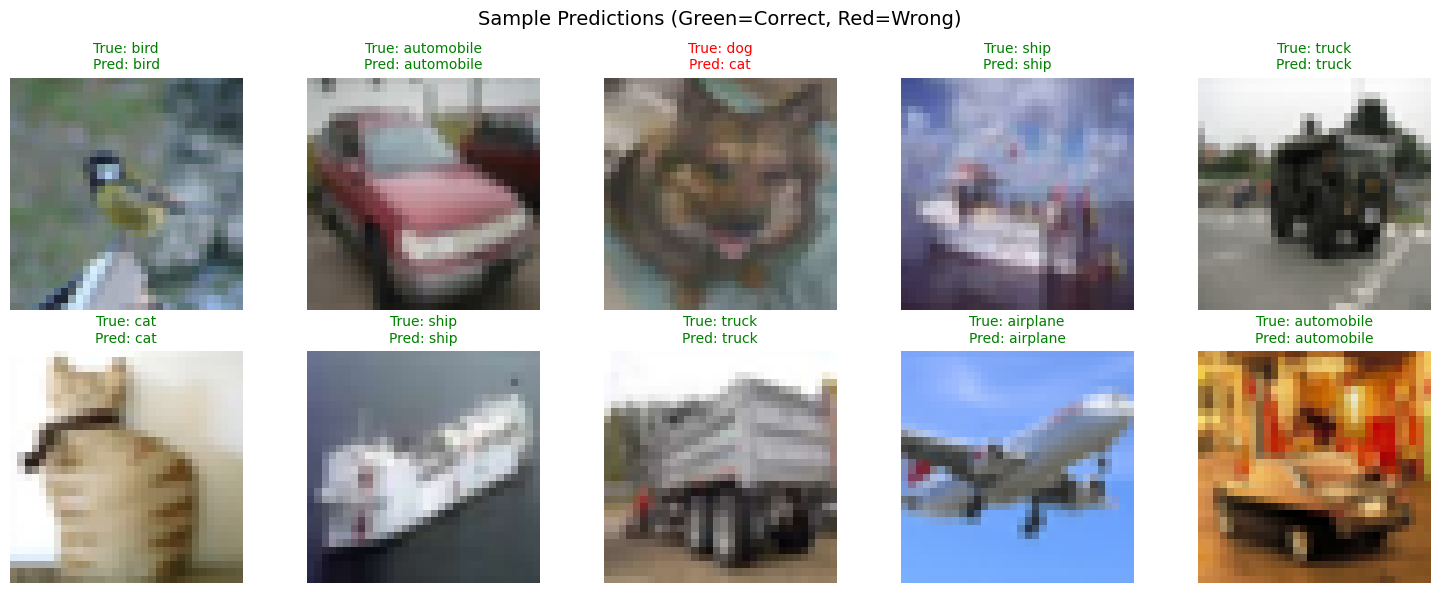

In [14]:
# ============================================================
# Cell 15: Sample Predictions Visualization
# ============================================================

# Get some sample images from validation set
raw_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

# Show random predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
indices = np.random.choice(len(raw_dataset), 10, replace=False)

for i, idx in enumerate(indices):
    ax = axes[i // 5, i % 5]
    img, true_label = raw_dataset[idx]
    pred_label = predictions[idx]
    
    ax.imshow(img)
    ax.axis('off')
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[pred_label]}', 
                 color=color, fontsize=10)

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.show()

## 7️⃣ Download Model

In [15]:
# ============================================================
# Cell 16: Download Best Model
# ============================================================
from google.colab import files

print(f"📁 Model guardado en: {model_path}")
print(f"📊 Accuracy: {best_val_acc*100:.2f}%")
print()

# Descargar automáticamente
files.download(model_path)
print("✅ Descarga iniciada! Mueve el archivo a tu proyecto:")


📁 Model guardado en: ./models/efficientnet_cifar10_best.pth
📊 Accuracy: 97.31%



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Descarga iniciada! Mueve el archivo a tu proyecto:


---

## 📝 Summary

### What We Did:
1. ✅ Loaded EfficientNet-B0 pretrained on ImageNet
2. ✅ Replaced classifier for CIFAR-10 (10 classes)
3. ✅ Trained with GPU acceleration
4. ✅ Used data augmentation for better generalization
5. ✅ Applied learning rate scheduling
6. ✅ Implemented early stopping to prevent overfitting
7. ✅ Saved best model checkpoint
8. ✅ Visualized results with confusion matrix

### Next Steps:
- Try `freeze_backbone = False` for fine-tuning (higher accuracy)
- Experiment with different learning rates
- Run the Grad-CAM analysis notebook for interpretability

---